# Search good hyper-parameters in Normalization
- It seems finding a good value helps a lot in performance

In [6]:
import sys
sys.path.append("../Share")
import config, utils, baseline, Trainer, Processing_same_with_MATLAB
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

baseline_K_val = [1] #Train ~18 session data, test with 19~
K = baseline_K_val[0]

feature_names = ['Zero Crossing (ZC)', 'Slope Sign Changes (SSC)', 'Waveform Length (WL)', 'WAMP', 'Mean Absolute Value (MAV)', 'Mean Square (MS)', 'Root Mean Square (RMS)',
                 'v-order 3 (V3)', 'log detector (LD)', 'difference absolute standard deviation value (DASDV)', 'maximum fractal length (MFL)', 'myopulse percentage rate (MPR)',
                 'mean absolute value slope (MAVS)', 'weighted mean absolute (WMS)',
                 'Cepstrum Coefficient 1', 'Cepstrum Coefficient 2', 'Cepstrum Coefficient 3', 'Cepstrum Coefficient Average', 'DWTC1', 'DWTC2',
                 'DWTPC1', 'DWTPC2', 'DWTPC3']


feature_idx = range(0,len(feature_names))

fs = round(10e6 / 2048)  # 4883 Hz
lower_cutoff = 100
upper_cutoff = 600
filter_b, filter_a = Processing_same_with_MATLAB.cheby2(4, 30, [lower_cutoff / (fs/2), upper_cutoff / (fs/2)], btype='bandpass')

feat_mean_1ch = np.array([0.1, 0.1, 2.5, 0.0, 11.0, 229.0, 13.8, -11.0, 9.0, 3.0, 1.5, 0.0, 0.0, 2.8])
feat_std_1ch = np.array([0.02, 0.05, 0.65, 0.02, 4.43, 303.9, 6.85, 12.18, 2.87, 0.87, 0.21, 0.04, 6.68, 1.12])
feat_mean = np.tile(feat_mean_1ch, (4, 1))
feat_std = np.tile(feat_std_1ch, (4, 1))

SUBJECT = "Carlson"
data_files = config.dataset_sub_C
default_path = config.default_path_sub_C

trainer = Trainer.TremorModelTrainer(config, subject=SUBJECT)

In [7]:
def Train_and_test(Normalization_TF):

    extractor = Processing_same_with_MATLAB.EMGFeatureExtractor(feat_mean, feat_std, filter_b, filter_a, Norm_bool=Normalization_TF)
    X_train_all, y_train_all, X_test_all, y_test_all, X_val_all, y_val_all = [], [], [], [], [], []
    unseen_test_result = []

    for idx, session_info in enumerate(data_files):
        print(f"Dataset {idx + 1}/{len(data_files)} - Session {session_info}\n{'='*40}")
        path = os.path.join(default_path, f'{session_info}raw/')
        features, class_labels = [], []
        for c_idx, c in enumerate(config.classes_5):
            raw_data = os.listdir(path+c)
            mat = scipy.io.loadmat(path+c+raw_data[0])
            extractor.buffer = mat['Data_ADC']
            class_labels.append(mat['Data_Cls'].reshape(-1))
            features_per_cls = extractor.extract_features(num_feature_set=23)
            features_per_cls = np.transpose(features_per_cls, (2, 0, 1))  # shape: (1729, 4, 14)
            features.append(features_per_cls)
            #print(features_per_cls.shape, mat['Data_Cls'].reshape(-1).shape)

        X = np.concatenate(features, axis=0)
        y = np.concatenate(class_labels, axis=0)
        if X.shape[0] != y.shape[-1]:
            print(f"Incorrect shape between features and Class: {X.shape} and {y.shape}, {session_info}")
            break

        if idx < K:
            X_train, y_train, X_val, y_val,  = utils.split_data(X, y, ratio=0.8)
            X_train_all.append(X_train)
            y_train_all.append(y_train)
            X_val_all.append(X_train)
            y_val_all.append(y_train)

        elif idx == K:
            X_train, y_train, X_test, y_test,  = utils.split_data(X, y, ratio=0.8)
            X_train_all.append(X_train)
            y_train_all.append(y_train)
            X_val_all.append(X_test)
            y_val_all.append(y_test)

            X_train_stacked = np.concatenate(X_train_all, axis=0)
            y_train_stacked = np.concatenate(y_train_all, axis=0)
            print(f"\t Training {K}: ", X_train_stacked.shape, y_train_stacked.shape)
            acc, pre_trained_CNN = trainer.train_multiple_dataset_2D(X_train, y_train, X_test, y_test)
            print(f"\t Accuracy on test dataset {idx+1}: {acc:.4f}%")

        else:
            X_test, y_test, _, _ = utils.split_data(X, y, ratio=1)
            X_test_all.append(X_test)
            y_test_all.append(y_test)
            X_test_stacked = np.concatenate(X_test_all, axis=0)
            y_test_stacked = np.concatenate(y_test_all, axis=0)

            X = np.expand_dims(X, axis=-1)
            acc = pre_trained_CNN.evaluate(X_test, y_test, verbose=0)[1]*100
            print(f"\t Accuracy on unseen dataset {idx+1}: {acc:.4f}%")
            unseen_test_result.append(acc)

    return unseen_test_result, X_train_stacked, y_train_stacked, X_test_stacked, y_test_stacked


def feature_wise_test(X_train_stacked, y_train_stacked, X_test_stacked, y_test_stacked):

    feature_acc = []

    for idx, f in enumerate(feature_idx):
        X_train = X_train_stacked[:, :, f:f+1, :]
        X_test = X_test_stacked[:, :, f:f+1, :]

        X_train = np.squeeze(X_train, axis=-1)  # Remove last dim → (100000, 4, 1)
        X_test = np.squeeze(X_test, axis=-1)

        print(X_train.shape, X_test.shape)

        acc, _ = trainer.train_multiple_dataset_1D(X_train, y_train_stacked, X_test, y_test_stacked)
        feature_acc.append(acc)
        print("\n")

    return feature_acc

def feature_vis(feature_names, feature_acc):
    feature_names_idx = feature_names #+ ['All features']

    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(feature_acc)), feature_acc, color='skyblue')
    plt.xticks(range(len(feature_acc)), feature_names_idx, rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.title('Feature-wise Accuracy')
    plt.tight_layout()

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)
    plt.show()

# Without Normalization

In [4]:
Normalization_TF = False ############################ important!!!!
noNorm_acc, X_train_stacked_noNorm, y_train_stacked_noNorm, X_test_stacked_noNorm, y_test_stacked_noNorm = Train_and_test(Normalization_TF)

Dataset 1/8 - Session Exp_2025-06-30-v1/E9AD0E7DCC2B/
Dataset 2/8 - Session Exp_2025-06-30-v2/E9AD0E7DCC2B/
	 Training 1:  (13641, 4, 23, 1) (13641,)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 82.07%
Maximum validation accuracy : 82.3%
Accuracy of test dataset using model V0: 82.2419%
	 Accuracy on test dataset 2: 82.3009%
Dataset 3/8 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
	 Accuracy on unseen dataset 3: 82.1714%
Dataset 4/8 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
	 Accuracy on unseen dataset 4: 83.1208%
Dataset 5/8 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
	 Accuracy on unseen dataset 5: 79.2121%
Dataset 6/8 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
	 Accuracy on unseen dataset 6: 80.9496%
Dataset 7/8 - Session Exp_2025-07-11-v1/E9AD0E7DCC2B/
	 Accuracy on unseen dataset 7: 81.6561%
Dataset 8/8 - Session Exp_2025-07-11-v2/E9AD0E7DCC2B/
	 Accuracy on unseen dataset 8: 81.9218%


In [8]:
feature_acc_noNorm = feature_wise_test(X_train_stacked_noNorm, y_train_stacked_noNorm, X_test_stacked_noNorm, y_test_stacked_noNorm)

(13641, 4, 1) (51743, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 79.97%
Maximum validation accuracy : 82.85%
Accuracy of test dataset using model V0: 82.8499%


(13641, 4, 1) (51743, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 81.04%
Maximum validation accuracy : 83.66%
Accuracy of test dataset using model V0: 83.6113%


(13641, 4, 1) (51743, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 83.68%
Maximum validation accuracy : 83.95%
Accuracy of test dataset using model V0: 83.9418%


(13641, 4, 1) (51743, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 74.05%
Maximum validation accuracy : 79.06%
Accuracy of test dataset using model V0: 78.2463%


(13641, 4, 1) (51743, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum t

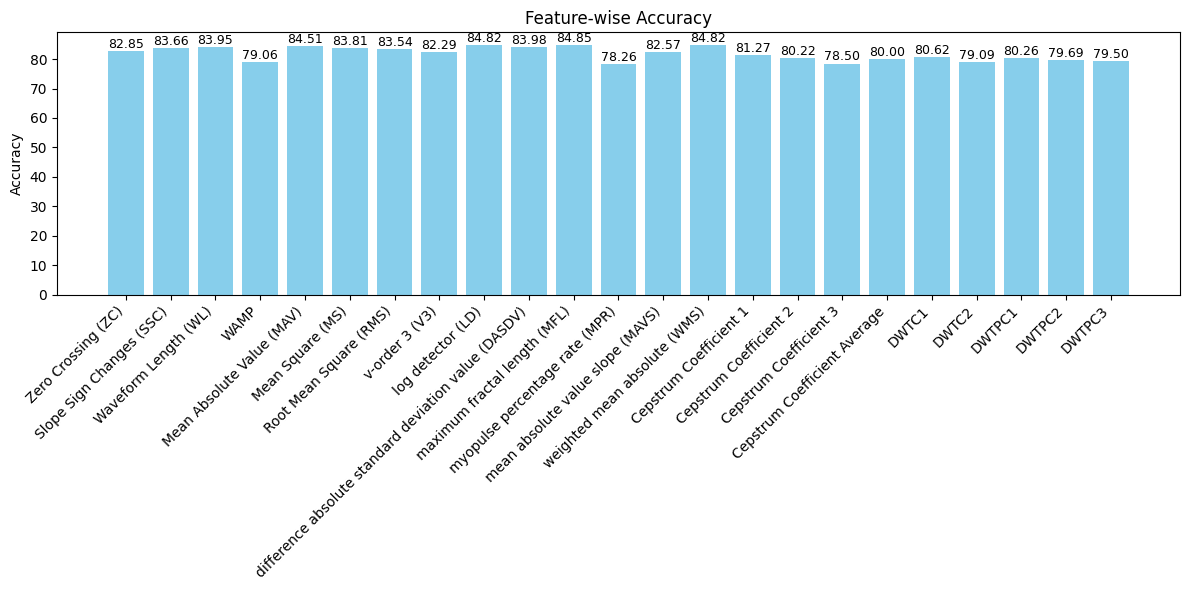

In [9]:
feature_vis(feature_names, feature_acc_noNorm)

In [10]:
Normalization_TF = True ############################ important!!!!
Norm_acc, X_train_stacked_Norm, y_train_stacked_Norm, X_test_stacked_Norm, y_test_stacked_Norm = Train_and_test(Normalization_TF)

Dataset 1/8 - Session Exp_2025-06-30-v1/E9AD0E7DCC2B/
Dataset 2/8 - Session Exp_2025-06-30-v2/E9AD0E7DCC2B/
	 Training 1:  (13641, 4, 23, 1) (13641,)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 83.34%
Maximum validation accuracy : 83.78%
Accuracy of test dataset using model V0: 83.6578%
	 Accuracy on test dataset 2: 83.7758%
Dataset 3/8 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
	 Accuracy on unseen dataset 3: 84.9901%
Dataset 4/8 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
	 Accuracy on unseen dataset 4: 84.5583%
Dataset 5/8 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
	 Accuracy on unseen dataset 5: 82.3870%
Dataset 6/8 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
	 Accuracy on unseen dataset 6: 83.8448%
Dataset 7/8 - Session Exp_2025-07-11-v1/E9AD0E7DCC2B/
	 Accuracy on unseen dataset 7: 84.7944%
Dataset 8/8 - Session Exp_2025-07-11-v2/E9AD0E7DCC2B/
	 Accuracy on unseen dataset 8: 84.7255%


In [11]:
feature_acc_Norm = feature_wise_test(X_train_stacked_Norm, y_train_stacked_Norm, X_test_stacked_Norm, y_test_stacked_Norm)

(13641, 4, 1) (51743, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 79.7%
Maximum validation accuracy : 83.07%
Accuracy of test dataset using model V0: 82.9716%


(13641, 4, 1) (51743, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 80.75%
Maximum validation accuracy : 83.45%
Accuracy of test dataset using model V0: 83.4451%


(13641, 4, 1) (51743, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 83.64%
Maximum validation accuracy : 84.78%
Accuracy of test dataset using model V0: 84.5293%


(13641, 4, 1) (51743, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 74.17%
Maximum validation accuracy : 79.06%
Accuracy of test dataset using model V0: 79.0117%


(13641, 4, 1) (51743, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum tr

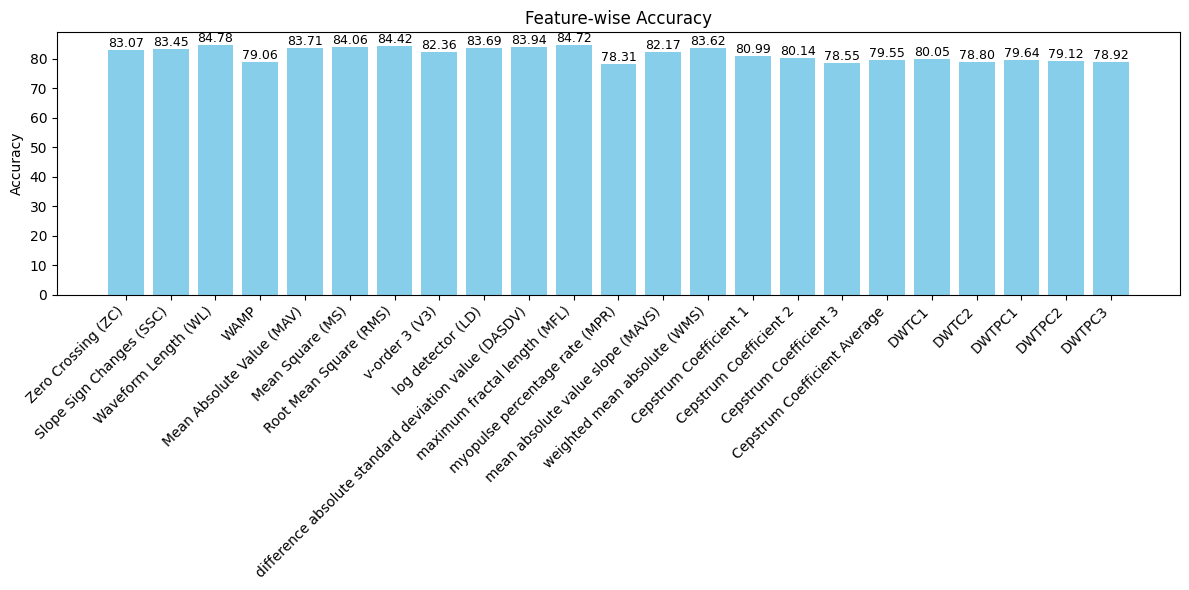

In [12]:
feature_vis(feature_names, feature_acc_Norm)

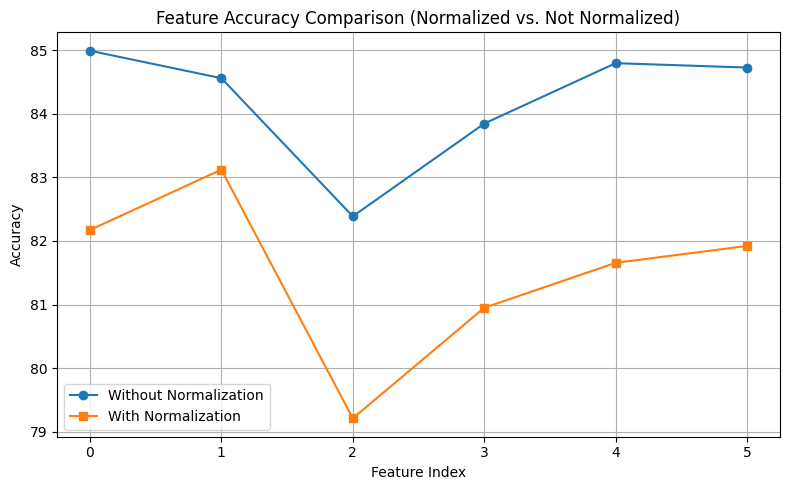

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(Norm_acc, label="Without Normalization", marker='o')
plt.plot(noNorm_acc, label="With Normalization", marker='s')
plt.title("Feature Accuracy Comparison (Normalized vs. Not Normalized)")
plt.xlabel("Feature Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

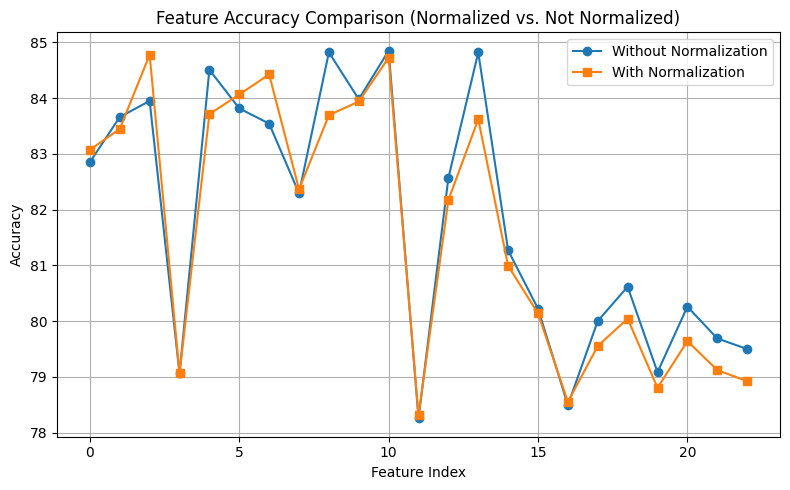

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(feature_acc_noNorm, label="Without Normalization", marker='o')
plt.plot(feature_acc_Norm, label="With Normalization", marker='s')
plt.title("Feature Accuracy Comparison (Normalized vs. Not Normalized)")
plt.xlabel("Feature Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Conclusion
- 피쳐 하나씩 돌릴때는 Normalization 안해도 큰 손실은 없음
- 여러개 돌릴때는 Normalization 중요
- 비슷하다면 Normalization 을 하고 돌리고 거기서 좋은 값 찾기